In [26]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os
import folium
import seaborn as sns
import json

# Constants 
CWD = pathlib.Path(os.path.abspath(""))
GIT_ROOT = CWD.parent
DATA_DIR = GIT_ROOT / "data" / 'SSMVSpring23'


In [ ]:
#older version- no need to run
def location_visual(file_path, start_time, end_time):

    # Step 1: Load the CSV File
    df = pd.read_csv(os.path.join(file_path, 'game_logs.csv'))

    # Step 2: Convert Datetime Column
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

    # Step 3: Extract Position Information
    df['position'] = df['event_data'].apply(lambda x: ast.literal_eval(x))

    # Step 4: Filter Data based on Time Range
    mask = (df['datetime'] >= start_time) & (df['datetime'] <= end_time)
    df = df[mask]

    # Step 5: Sample the data to reduce the number of markers
    sampled_rows = []
    seen_ids = set()

    for _, group in df.groupby(df['datetime'].dt.second):
        for _, row in group.iterrows():
            id_val = ast.literal_eval(row['event_data'])['id']
            if id_val not in seen_ids:
                sampled_rows.append(row)
                seen_ids.add(id_val)

    sampled_df = pd.DataFrame(sampled_rows).reset_index(drop=True)

    # Step 6: Convert 'event_data' to a dictionary
    sampled_df['position'] = sampled_df['event_data'].apply(lambda x: ast.literal_eval(x))

    # Step 7: Group the data by second
    grouped_df = sampled_df.groupby('datetime')

    # Save sampled data to a CSV file
    sampled_df.to_csv(os.path.join(file_path, 'sampled_data.csv'), index=False)

    # Step 8: Create a plot for every second
    for second, group in grouped_df:
        if not group.empty:
            plt.figure()
            plt.title(f'Positions at {second}')

            # Dictionary to store colors for each ID
            id_colors = {}

            # Plot the positions for each ID
            for idx, row in group.iterrows():
                position = row['position']
                id_val = position['id']

                # Get color for the ID, use the same color if ID already seen
                color = id_colors.get(id_val, None)
                if color is None:
                    color = plt.cm.rainbow(len(id_colors) / len(group))
                    id_colors[id_val] = color

                plt.scatter(float(position['x']), float(position['y']), label=f'ID: {id_val}', color=color)

            plt.xlabel('X Position')
            plt.ylabel('Y Position')
            plt.legend()
            plt.show()    

The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st' exists.


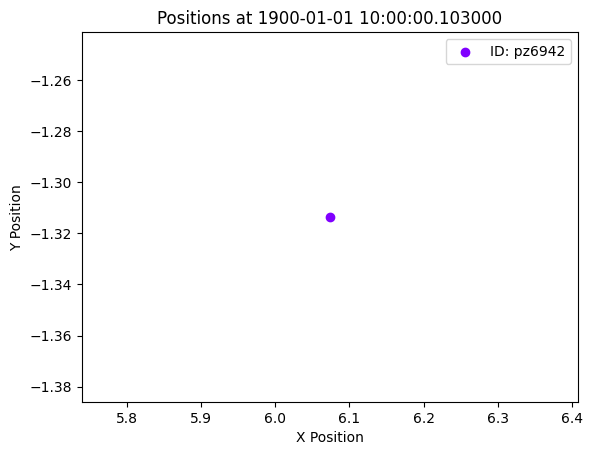

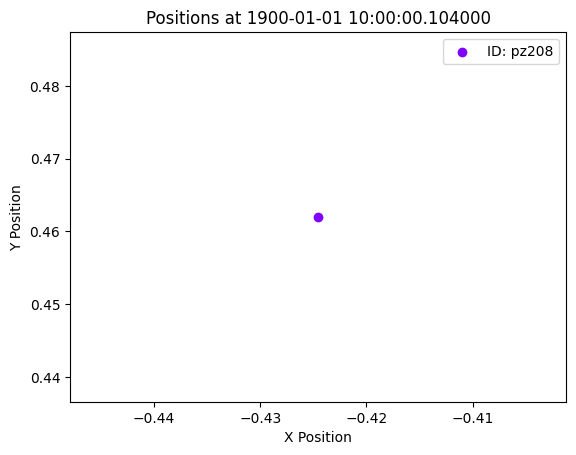

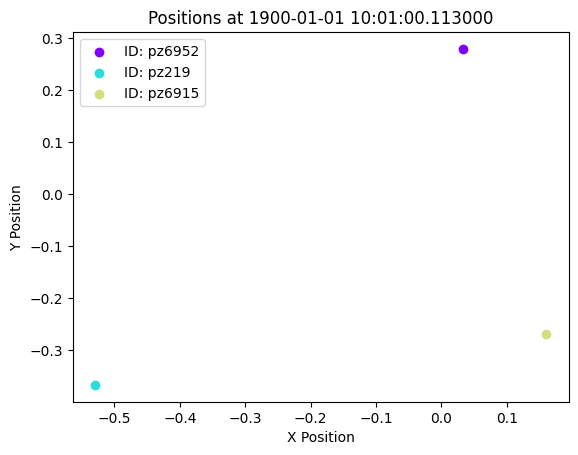

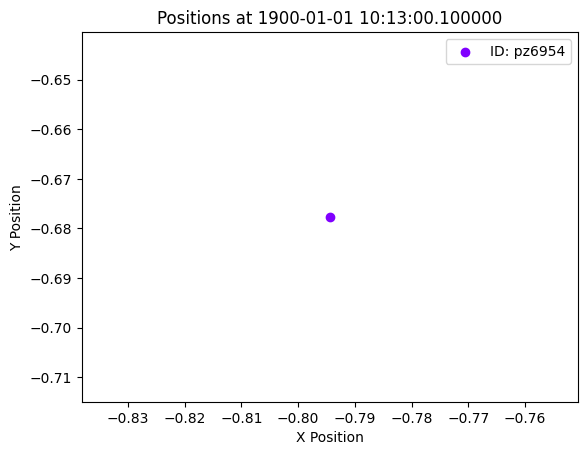

The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st/sampled_data.csv' exists.


In [101]:
#older version- no need to run
#collect inputs:
file_path = str(DATA_DIR / 'logs' / 'Day1- 1st')
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

# Set file path and time range
start_time = pd.to_datetime('1900-01-01 10:00:00', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('1900-01-01 11:00:00', format='%Y-%m-%d %H:%M:%S')

# Run the function
location_visual(file_path, start_time, end_time)

file_path = str(DATA_DIR / 'logs' / 'Day1- 1st' / 'sampled_data.csv')
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")


In [72]:
def create_sampled_data_file(file_path, start_time, end_time):
    # Step 1: Load the CSV File
    df = pd.read_csv(os.path.join(file_path, 'game_logs.csv'))

    # Step 2: Convert Datetime Column
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

    # Step 3: Extract Position Information
    df['event_data'] = df['event_data'].apply(lambda x: ast.literal_eval(x))
    df['id'] = df['event_data'].apply(lambda x: x['id'])

    # Step 4: Filter Data based on Time Range
    mask = (df['datetime'] >= start_time) & (df['datetime'] <= end_time)
    df = df[mask]

    # Round the datetime column to seconds
    df['datetime'] = df['datetime'].dt.floor('S')

    # Step 5: Sample the data to keep only the first row for each ID in each second
    sampled_df = df.groupby(['datetime', 'id'], as_index=False).first()

    # Step 6: Sort by time
    sampled_df.sort_values('datetime', inplace=True)

    # Step 7: Merge all rows with the same second into one row
    sampled_df = sampled_df.groupby('datetime').agg({
        'event_data': lambda x: [{
            'id': entry['id'],
            'position': {
                'x': entry['x'],
                'y': entry['y']
            }
        } for entry in x]
    }).reset_index()

    # Step 8: Convert 'event_data' to the requested JSON format using json.dumps
    sampled_df['event'] = sampled_df['event_data'].apply(lambda positions: json.dumps({"positions": positions}))

    # Save sampled data to a CSV file
    sampled_df[['datetime', 'event']].to_csv(os.path.join(file_path, 'sampled_data.csv'), index=False, sep='\t')


In [81]:
def plot_all_positions(file_path):
    # Load the sampled data from the CSV file
    sampled_df = pd.read_csv(os.path.join(file_path, 'sampled_data.csv'), sep='\t')

    # Use seaborn to set consistent colors for the same ID
    sns.set_palette("husl")

    # Create a plot for every second
    for second, group in sampled_df.groupby('datetime'):
        if not group.empty:
            plt.figure()
            plt.title(f'Positions at {second}')

            # Plot the positions for each ID
            for idx, row in group.iterrows():
                positions = json.loads(row['event'])['positions']
                for position in positions:
                    id_val = position['id']
                    x_val = float(position['position']['x'])
                    y_val = float(position['position']['y'])

                    plt.scatter(x_val, y_val, label=f'ID: {id_val}')

            plt.xlabel('X Position')
            plt.ylabel('Y Position')
            plt.legend()
            plt.show()

In [73]:
file_path = str(DATA_DIR / 'logs' / 'Day1- 1st')
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")

# Set file path and time range
start_time = pd.to_datetime('1900-01-01 10:00:00', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('1900-01-01 11:00:00', format='%Y-%m-%d %H:%M:%S')

# Run the function to create the sampled data file
create_sampled_data_file(file_path, start_time, end_time)



The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st' exists.


TypeError: string indices must be integers

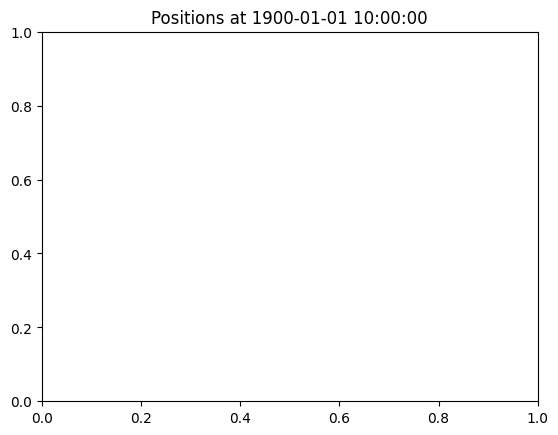

In [82]:
# Run the function to plot positions
file_path = str(DATA_DIR / 'logs' / 'Day1- 1st')
plot_all_positions(file_path)

In [106]:
def Plot_positions_one_plot(processed_data_path):
    # Load the sampled data from the CSV file
    sampled_df = pd.read_csv(os.path.join(processed_data_path, 'sampled_data.csv'))

    # Dictionary to store colors for each ID
    id_colors = {}

    # Create a plot with lines connecting positions for each ID
    plt.figure(figsize=(10, 6))
    for id_val, group in sampled_df.groupby('id'):
        color = id_colors.get(id_val, None)
        if color is None:
            color = plt.cm.rainbow(len(id_colors) / len(sampled_df['your_id_column_name'].unique()))  # Adjust column name
            id_colors[id_val] = color

        plt.plot(group['position_x'], group['position_y'], label=f'ID: {id_val}', color=color, marker='o')

    plt.xlabel('X Position (Longitude)')
    plt.ylabel('Y Position (Latitude)')
    plt.title('Movement of IDs over Time')
    plt.legend()
    plt.show()




In [107]:
# print one plot for every second

#collect inputs:
prossesed_file_path = str(DATA_DIR / 'logs' / 'Day1- 1st')
if os.path.exists(prossesed_file_path):
    print(f"The file '{prossesed_file_path}' exists.")
else:
    print(f"The file '{prossesed_file_path}' does not exist.")

# Run the function
Plot_positions_one_plot(prossesed_file_path)

The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st' exists.


KeyError: 'id'

<Figure size 1000x600 with 0 Axes>

In [ ]:
#plot for every file - need to be fixed
for subdir in (DATA_DIR / 'logs').iterdir():
    if subdir.is_dir():
        for csv_file in subdir.glob('game_logs.csv'):
            # Get the full file path
            file_path = str(csv_file)
            # Set file path and time range
            start_time = pd.to_datetime('1900-01-01 09:49:00', format='%Y-%m-%d %H:%M:%S')
            end_time = pd.to_datetime('1900-01-01 09:52:00', format='%Y-%m-%d %H:%M:%S')

            if os.path.exists(file_path):
                print(f"The file '{file_path}' exists.")
            else:
                print(f"The file '{file_path}' does not exist.")
            location_visual(file_path, start_time, end_time)



The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day3- 3rd/game_logs.csv' exists.
DataFrame is empty. No positions to plot.
The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st/game_logs.csv' exists.
The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 2nd/game_logs.csv' exists.
DataFrame is empty. No positions to plot.
The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day3- 2nd/game_logs.csv' exists.
DataFrame is empty. No positions to plot.
The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day3- 1st/game_logs.csv' exists.
DataFrame is empty. No positions to plot.


The file '/Users/efratdim/dev/EmbodiedLearningProject/data/SSMVSpring23/logs/Day1- 1st/game_logs.csv' exists.


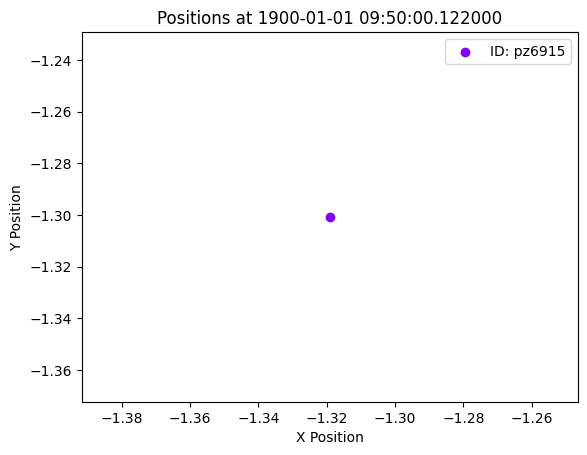

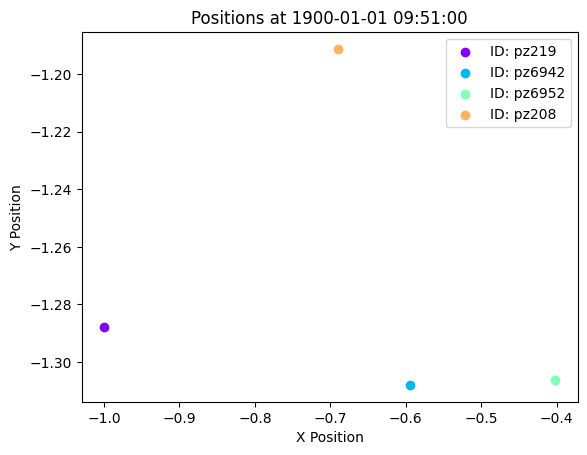

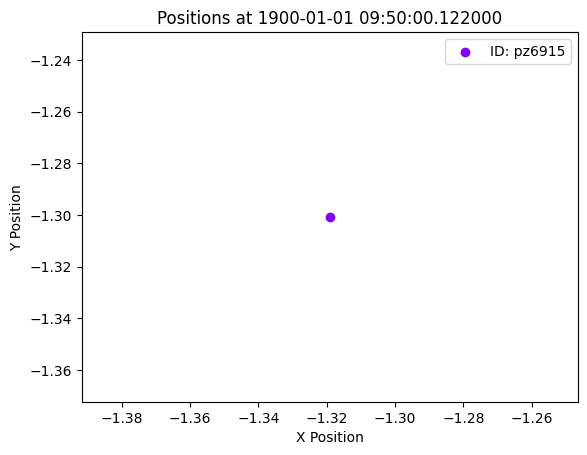

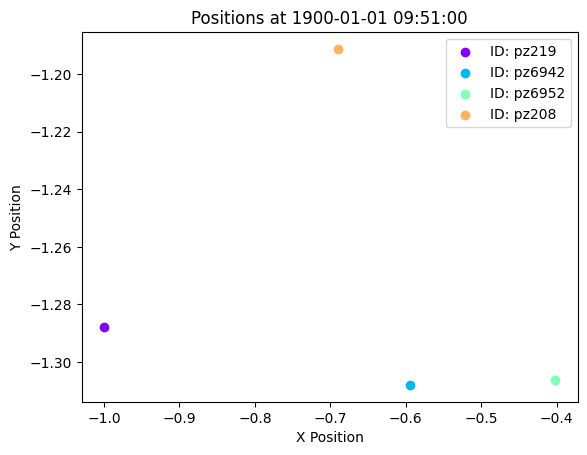

In [68]:
#collect inputs:
file_path = str(DATA_DIR / 'logs' / 'Day1- 1st' / 'game_logs.csv')
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")
location_visual(file_path, start_time, end_time)
# Set file path and time range
start_time = pd.to_datetime('1900-01-01 09:49:00', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('1900-01-01 09:52:00', format='%Y-%m-%d %H:%M:%S')

# Run the function
location_visual(file_path, start_time, end_time)